In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

from scipy import stats
import collections

import warnings
# warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

from pathlib import Path

import db_queries as db
import vivarium_helpers.id_helper as idh
import gbd_mapping
from vivarium import Artifact

# Add the repo directory vivarium_research_ciff_sam/ to sys.path
import os, sys
repo_path = os.path.abspath('../..')
sys.path.append(repo_path)
# Assumes vivarium_research_ciff_sam/ is in sys.path
import model_validation.vivarium_transformed_output as vto
# import model_validation.vivarium_raw_output as vro
import model_validation.vivarium_output_processing as vop
import model_validation.ciff_sam_results as csr

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff_sam/model_validation/model4
ndbs
Wed Sep 22 17:53:39 PDT 2021


In [3]:
%load_ext autoreload
%autoreload 2

# Validation and Verification Criteria from SQLNS documentation

[SQLNS documentation on Vivarium Research](https://vivarium-research.readthedocs.io/en/latest/intervention_models/lipid_based_nutrient_supplements/index.html)

1. verification: coverage of SQ-LNS as a function of time in baseline and intervention scenario

2. verification: prevalence of stunting in supplemented vs non-supplemented group

3. verification: incidence of moderate wasting from mild in supplemented vs non-supplemented group

4. validation: check that the prevalence of moderate wasting in supplemented vs non-supplemented group agrees with the prevalence RR that we applied to the incidence instead.

5. validation: check to see how much of SAM prevalence decreases from reduction in MAM incidence from MILD.

Additional checks:

6. validation: make sure changes in prevalence of MILD and TMREL wasting categories with SQLNS look reasonable

7. verification: check that prevalence of wasting and stunting categories among the untreated in the intervention scenario match the prevalences in the baseline scenario

# Load output from model 4.0 (wasting treatment) and compute total person time

In [4]:
data = csr.VivariumResults.cleaned_from_model_spec(4.0)
data.compute_total_person_time()
data.table_names()

['wasting_transition_count',
 'wasting_state_person_time',
 'deaths',
 'stunting_state_person_time',
 'population',
 'ylls',
 'ylds',
 'cause_state_person_time',
 'cause_transition_count',
 'person_time']

In [5]:
data.wasting_state_person_time

,sex,year,wasting_state,measure,input_draw,scenario,value,sq_lns,wasting_treatment,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,covered,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,uncovered,early_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,144.720055,uncovered,covered,early_neonatal
3,female,2022,mild_child_wasting,state_person_time,29,baseline,149.426420,uncovered,uncovered,early_neonatal
...,...,...,...,...,...,...,...,...,...,...
34556,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,0.000000,covered,covered,2_to_4
34557,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,0.000000,covered,uncovered,2_to_4
34558,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,0.000000,uncovered,covered,2_to_4
34559,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,15488.375086,uncovered,uncovered,2_to_4


In [6]:
data.wasting_state_person_time.scenario.unique()

array(['baseline', 'sqlns', 'wasting_treatment'], dtype=object)

# 1. Check SQ-LNS coverage as a function of time

Target is 90% coverage for 6 months and older, starting in 2023, 0% coverage under 6 months and in 2022.

In [7]:
# Calculate sqlns coverage and split into separate baseline and intervention dataframes
sqlns_coverage_by_age_year = csr.get_sqlns_coverage(data, ['age', 'year'])
sqlns_coverage_baseline = sqlns_coverage_by_age_year.query("scenario=='baseline'")
sqlns_coverage_intervention = sqlns_coverage_by_age_year.query("scenario=='sqlns'")

In [8]:
sqlns_coverage_by_age_year

,age,year,input_draw,scenario,sq_lns,value,numerator_measure,denominator_measure,multiplier
0,1-5_months,2022,29,baseline,covered,0.0,state_person_time,person_time,1
1,1-5_months,2022,29,baseline,uncovered,1.0,state_person_time,person_time,1
2,1-5_months,2022,29,sqlns,covered,0.0,state_person_time,person_time,1
3,1-5_months,2022,29,sqlns,uncovered,1.0,state_person_time,person_time,1
...,...,...,...,...,...,...,...,...,...
2156,late_neonatal,2026,946,sqlns,covered,0.0,state_person_time,person_time,1
2157,late_neonatal,2026,946,sqlns,uncovered,1.0,state_person_time,person_time,1
2158,late_neonatal,2026,946,wasting_treatment,covered,0.0,state_person_time,person_time,1
2159,late_neonatal,2026,946,wasting_treatment,uncovered,1.0,state_person_time,person_time,1


## Check that covered + uncovered == 1 and baseline coverage is 0

Looks goos.

In [9]:
# Check that covered + uncovered always adds up to 1 in the full dataframe
assert np.allclose(vop.marginalize(sqlns_coverage_by_age_year, 'sq_lns').value, 1),\
    "SQLNS coverage plus non-coverage doesn't add up to 100%!"

In [10]:
# Check that baseline coverage is 0 (in the baseline dataframe)
assert (sqlns_coverage_baseline.query("sq_lns=='covered'").value == 0).all(),\
    "There is nonzero SQLNS coverage in baseline scenario!"

## Check that coverage under 6 months is always 0

Looks good.

In [11]:
under_6mo = ['early_neonatal', 'late_neonatal', '1-5_months']
over_6mo = ['6-11_months', '12_to_23_months', '2_to_4']

In [12]:
# Filter to ages under 6mo in intervention dataframe
sqlns_coverage_under_6mo = sqlns_coverage_intervention.query("age in @under_6mo and sq_lns == 'covered'")
# vop.describe(vop.marginalize(sqlns_coverage_under_6mo, 'age'))

In [13]:
# Check that coverage under 6 months is always 0
assert (sqlns_coverage_under_6mo.value == 0).all(),\
    "There is nonzero SQLNS coverage in age groups under 6 months!"

## Check that for age > 6mo, coverage goes from 0% in 2022 to 90% in 2023

First get coverage data for age groups > 6 months.

In [14]:
# Filter to ages over 6mo in intervention dataframe
sqlns_coverage_over_6mo = sqlns_coverage_intervention.query("age in @over_6mo and sq_lns == 'covered'")
sqlns_coverage_over_6mo

,age,year,input_draw,scenario,sq_lns,value,numerator_measure,denominator_measure,multiplier
362,12_to_23_months,2022,29,sqlns,covered,0.000000,state_person_time,person_time,1
368,12_to_23_months,2022,223,sqlns,covered,0.000000,state_person_time,person_time,1
374,12_to_23_months,2022,232,sqlns,covered,0.000000,state_person_time,person_time,1
380,12_to_23_months,2022,357,sqlns,covered,0.000000,state_person_time,person_time,1
...,...,...,...,...,...,...,...,...,...
1418,6-11_months,2026,650,sqlns,covered,0.898288,state_person_time,person_time,1
1424,6-11_months,2026,680,sqlns,covered,0.896783,state_person_time,person_time,1
1430,6-11_months,2026,829,sqlns,covered,0.900669,state_person_time,person_time,1
1436,6-11_months,2026,946,sqlns,covered,0.901135,state_person_time,person_time,1


## Check that coverage is always 0 in 2022 and and is 90% in 2023-2026

Looks good. Coverage is 0% in 2022.

In [15]:
# Check that coverage in 2022 is always zero for ages over 6 months
assert (sqlns_coverage_over_6mo.query("year == '2022'").value == 0).all(),\
    "There is nonzero SQLNS coverage in year 2022!"

## Define a function to plot values over time for each age group and plot SQLNS coverage

Looks good. Coverage is close to 90% for all age groups for all years >= 2023.

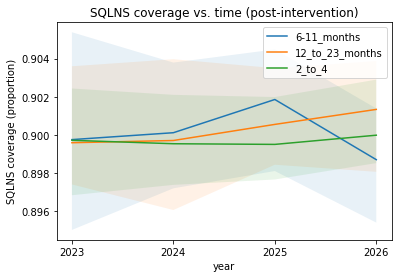

In [16]:
def plot_over_time_by_age(df, ylabel='', title='', ax=None):
    """Plot mean value vs. year for each age, with (upper, lower) uncertainty band."""
    if ax is None:
        ax = plt.gca()
    df = csr.age_to_ordered_categorical(df) # Order the age groups chronologically
    agg = df.groupby(['age', 'year'])['value'].describe(percentiles=[.025, .975])
    ages = agg.index.unique('age')
    for age in ages:
        values = agg.xs(age)
        years = values.index
        ax.plot(years, values['mean'], label=age)
        ax.fill_between(years, values['2.5%'], values['97.5%'], alpha=.1)
        
    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

plot_over_time_by_age(
    sqlns_coverage_over_6mo.query("year >'2022'"),
    "SQLNS coverage (proportion)",
    "SQLNS coverage vs. time (post-intervention)" 
);

## Define a similar function to plot trajectories for all draws rather than just an uncertainty band

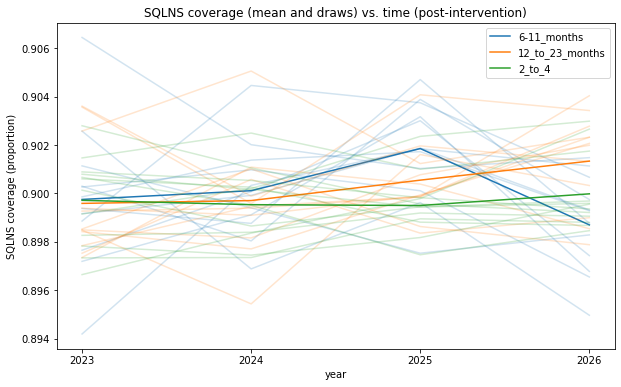

In [32]:
def plot_draws_over_time_by_age(df, ylabel='', title='', ax=None):
    """Plot mean value vs. year for each age, with (upper, lower) uncertainty band.
    https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
    https://matplotlib.org/stable/gallery/color/color_cycle_default.html
    https://matplotlib.org/stable/tutorials/introductory/customizing.html
    """
    if ax is None:
        ax = plt.gca()
    df = csr.age_to_ordered_categorical(df) # Order the age groups chronologically
# Does the same thing as .pivot:
#     draws_by_age_year = df.set_index(['age', 'year', 'input_draw'])['value'].unstack('input_draw')
#     draws_by_age_year = df.pivot(index=['age', 'year'], columns='input_draw', values='value')
    # Use .stratify to aggregate over sex and any other columns as necessary
    # .stratify puts 'input_draw' and 'scenario' in the index as well as the strata
#     draws_by_age_year = vop.stratify(df, ['age', 'year'], reset_index=False).unstack('input_draw')['value']
    draws_by_age_year = df.groupby(
        ['age', 'year', 'input_draw'], observed=True # observed=True needed to omit unused age categories
    )['value'].mean().unstack('input_draw')
    ages = draws_by_age_year.index.unique('age') # These should be sorted automatically
#     color = iter(plt.cm.tab20(np.linspace(0, 1, len(ages))))
    prop_cycle = plt.rcParams['axes.prop_cycle']
    color = iter(prop_cycle.by_key()['color'])
#     print(type(color))
    for age in ages:
        draws_by_year = draws_by_age_year.xs(age)
        years = draws_by_year.index.get_level_values('year')
        c = next(color)
        ax.plot(years, draws_by_year.mean(axis=1), label=f"{age}", c=c)
        for draw in draws_by_year.columns:
            ax.plot(years, draws_by_year[draw], c=c, alpha=.2)
        
    ax.set_xlabel('year')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend()
    return ax

fig, ax = plt.subplots(figsize=(10,6))
plot_draws_over_time_by_age(
    sqlns_coverage_over_6mo.query("year >'2022'"),
    "SQLNS coverage (proportion)",
    "SQLNS coverage (mean and draws) vs. time (post-intervention)",
    ax=ax
);

# 2. Verify prevalence of stunting in supplemented vs non-supplemented group

See [SQ-LNS Vivarium Modeling Strategy](https://vivarium-research.readthedocs.io/en/latest/intervention_models/lipid_based_nutrient_supplements/index.html#vivarium-modeling-strategy)

Target prevalence ratios Pr(cat_i | SQLNS) / Pr(cat_i | no SQLNS):
- cat1 (severe stunting): 0.85 (95% CI 0.74 to 0.98)
- cat2 (moderate stunting): 0.93 (95% CI 0.88 to 0.98)
- cat3 (mild stunting): Ratio depends on the category prevalences for the stratum -- should be greater than 1
- cat4 (TMREL): 1.0 (no uncertainty)

We'll compute the prevalence ratios for each (year, sex, age, draw) combination for which both SQLNS-covered person-time and SQLNS-uncovered person-time is nonzero. There are 288 such combinations: (1 intervention scenario) x (4 years > 2022) x (2 sexes) x (3 age groups > 6mo) x (12 draws).
 
First define some functions that will be useful later.

In [33]:
def normal_dist_from_mean_lower_upper(mean, lower, upper, scale_factor=1, quantile_ranks=(0.025,0.975)):
    """Returns a frozen normal distribution with the specified mean, such that
    (lower, upper) are approximately equal to the quantiles with ranks
    (quantile_ranks[0], quantile_ranks[1]).
    The `scale_factor` parameter allows scaling the resulting distribution by a specified factor.
    """
    # quantiles of the standard normal distribution with specified quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    stdev = (upper - lower) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    # Frozen normal distribution
    return stats.norm(loc=mean, scale=stdev*scale_factor)

def lognorm_from_median_lower_upper(median, lower, upper, quantile_ranks=(0.025,0.975)):
    """Returns a frozen lognormal distribution with the specified median, such that
    the values (lower, upper) are approximately equal to the quantiles with ranks
    (quantile_ranks[0], quantile_ranks[1]). More precisely, if q0 and q1 are
    the quantiles of the returned distribution with ranks quantile_ranks[0]
    and quantile_ranks[1], respectively, then q1/q0 = upper/lower. If the
    quantile ranks are symmetric about 0.5, lower and upper will coincide with
    q0 and q1 precisely when median^2 = lower*upper.
    """
    # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
    # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
    # We will determine sigma from the two specified quantiles lower and upper.

    # mean (and median) of the normal random variable Y = log(X)
    mu = np.log(median)
    # quantiles of the standard normal distribution corresponding to quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    # quantiles of Y = log(X) corresponding to the quantiles (lower, upper) for X
    norm_quantiles = np.log([lower, upper])
    # standard deviation of Y = log(X) computed from the above quantiles for Y
    # and the corresponding standard normal quantiles
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    # Frozen lognormal distribution for X = exp(Y)
    # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
    return stats.lognorm(s=sigma, scale=median)

def plot_pdf(dist, label, ax=None):
    """Plot the probability density function of a scipy.stats frozen distribution."""
    if ax is None: ax = plt.gca()
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
    ax.plot(x, dist.pdf(x), lw=2, alpha=0.8, label=label)

### Should the uncertainty distribution be normal or lognormal (or something else)?

Not sure, since these are ratios of random variables in [0,1]. See these references:

- https://en.wikipedia.org/wiki/Ratio_distribution
- https://mathoverflow.net/questions/147207/distribution-and-moments-of-ratio-of-two-beta-variables
- [Distributions of the ratios of independent beta variables and applications](https://www.tandfonline.com/doi/abs/10.1080/03610920008832632#.UntahHCtVAI) by T. Pham-Gia

Might be worth looking at the sources where we got the confidence intervals from.

Based on computing geometric and arithmetic means to check the symmetry of the confidence intervals, it looks like lognormal would be a better fit for the `cat1` effect size, and either normal or lognormal could be reasonable for the `cat2` effect size.

In [34]:
print(np.sqrt(.74*.98), (.74+.98)/2)

0.8515867542417507 0.86


In [35]:
print(np.sqrt(.88*.98), (.88+.98)/2)

0.928654941299512 0.9299999999999999


## Look at input data for stunting prevalence ratios

In [36]:
data.stunting_state_person_time

,sex,year,stunting_state,measure,input_draw,scenario,value,sq_lns,age
0,female,2022,cat1,state_person_time,29,baseline,0.000000,covered,early_neonatal
1,female,2022,cat1,state_person_time,29,baseline,0.000000,uncovered,early_neonatal
2,female,2022,cat1,state_person_time,29,baseline,0.000000,covered,late_neonatal
3,female,2022,cat1,state_person_time,29,baseline,0.000000,uncovered,late_neonatal
...,...,...,...,...,...,...,...,...,...
17276,male,2026,cat4,state_person_time,946,wasting_treatment,0.000000,covered,12_to_23_months
17277,male,2026,cat4,state_person_time,946,wasting_treatment,35399.828884,uncovered,12_to_23_months
17278,male,2026,cat4,state_person_time,946,wasting_treatment,0.000000,covered,2_to_4
17279,male,2026,cat4,state_person_time,946,wasting_treatment,89160.422998,uncovered,2_to_4


## Calculate the prevalence ratios

Should we stratify by year, or not??? Omitting year stratification decreases the variance in the computed prevalence ratios. Not sure what that means or whether it's desirable for verification purposes.

Note from Abie in [PR 28](https://github.com/ihmeuw/vivarium_research_ciff_sam/pull/28):

> > Should we stratify by year, or not???
>
> Benefit is it might show visually if there is anything funny happening year-over-year. So take a look visually. But for a quantitative/automatic test, combining years reduces the frequency of failing a test because of chance fluctuations.

In [37]:
stunting_prevalence_ratio = csr.get_sqlns_risk_prevalence_ratio(data, 'stunting', stratify_by_year=True)
stunting_prevalence_ratio

,year,sex,age,stunting_state,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier
0,2023,female,12_to_23_months,cat1,29,sqlns,0.789310,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
1,2023,female,12_to_23_months,cat1,223,sqlns,0.814896,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
2,2023,female,12_to_23_months,cat1,232,sqlns,0.772547,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
3,2023,female,12_to_23_months,cat1,357,sqlns,0.797292,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
...,...,...,...,...,...,...,...,...,...,...
1148,2026,male,6-11_months,cat4,650,sqlns,1.021409,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
1149,2026,male,6-11_months,cat4,680,sqlns,1.001229,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
1150,2026,male,6-11_months,cat4,829,sqlns,0.996429,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
1151,2026,male,6-11_months,cat4,946,sqlns,0.988949,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1


## How much do the prevalence ratios vary across draws within each stratum?

Each row of the below table describes the distribution across draws for a single stratum.

Looks like each row reasonably matches our lognormal distribution with median .85 (95% CI .74 to.98)

In [38]:
# How much do the prevalence ratios vary across draws within each stratum?
# Looks like from about .80-.83 to .88-.91 from the 8 visible rows
vop.describe(stunting_prevalence_ratio.query("stunting_state=='cat1'"))

count  \
age             denominator_measure              multiplier numerator_measure              scenario sex    stunting_state year          
12_to_23_months prevalence_among_sqlns_uncovered 1          prevalence_among_sqlns_covered sqlns    female cat1           2023   12.0   
                                                                                                                          2024   12.0   
                                                                                                                          2025   12.0   
                                                                                                                          2026   12.0   
...                                                                                                                               ...   
6-11_months     prevalence_among_sqlns_uncovered 1          prevalence_among_sqlns_covered sqlns    male   cat1           2023   12.0   
                                                                                                                          2024   12.0   
                                                                                                                          2025   12.0   
                                                                                                                          2026   12.0   

                                                                                                                                    mean  \
age             denominator_measure              multiplier numerator_measure              scenario sex    stunting_state year             
12_to_23_months prevalence_among_sqlns_uncovered 1          prevalence_among_sqlns_covered sqlns    female cat1           2023  0.832130   
                                                                                                                          2024  0.829799   
                                                                                                                          2025  0.839672   
                                                                                                                          2026  0.841073   
...                                                                                                                                  ...   
6-11_months     prevalence_among_sqlns_uncovered 1          prevalence_among_sqlns_covered sqlns    male   cat1           2023  0.844712   
                                                                                                                          2024  0.837371   
                                                                                                                          2025  0.850841   
                                                                                                                          2026  0.837217   

                                                                                                                                     std  \
age             denominator_measure              multiplier numerator_measure              scenario sex    stunting_state year             
12_to_23_months prevalence_among_sqlns_uncovered 1          prevalence_among_sqlns_covered sqlns    female cat1           2023  0.070756   
                                                                                                                          2024  0.065335   
                                                                                                                          2025  0.061922   
                                                                                                                          2026  0.058729   
...                                                                                                                                  ...   
6-11_months     prevalence_among_sqlns_uncovered 1          prevalence_among_sqlns_covered sqlns   

## How much do the prevalence ratios vary across strata within a single draw?

Each row of the below table describes the distribution across strata for a single draw.

We expect the means across strata for the 12 draws to look like 12 values drawn from the lognormal distribution with mean 0.85 and central 95% interval (0.74, 0.98) -- see sample values and Q-Q plot below.

It looks like

In [39]:
# How much do the prevalence ratios vary across strata within a single draw?
# from about .77-.82 to .89-.91, similar to the variation between draws above
stunting_prevalence_ratio.query(
    "stunting_state=='cat1'"
).groupby('input_draw').value.describe(percentiles=[.025,.975])

,count,mean,std,min,2.5%,50%,97.5%,max
input_draw,,,,,,,,
29,24.0,0.791893,0.028914,0.730317,0.730817,0.795713,0.829901,0.838908
223,24.0,0.811804,0.019449,0.768914,0.774996,0.811013,0.850307,0.865094
232,24.0,0.832436,0.029784,0.772547,0.782904,0.828392,0.893553,0.916251
357,24.0,0.808978,0.025922,0.783598,0.783655,0.802068,0.874313,0.899025
...,...,...,...,...,...,...,...,...
650,24.0,0.873360,0.024849,0.834239,0.839984,0.871655,0.928398,0.950377
680,24.0,0.863765,0.016595,0.834884,0.837853,0.863823,0.900449,0.903790
829,24.0,0.930962,0.018854,0.909925,0.910359,0.924696,0.972138,0.978260
946,24.0,0.817881,0.030393,0.745024,0.762250,0.811289,0.869195,0.880239


## Make an empirical Q-Q plot of the mean prevalence ratio by draw vs. a 12-draw sample from the specified lognormal distribution

In [70]:
mean_prevalence_ratio_by_draw = stunting_prevalence_ratio.query(
    "stunting_state=='cat1'"
).groupby('input_draw').value.mean().sort_values()
mean_prevalence_ratio_by_draw.to_frame().T

input_draw,629,29,357,223,946,602,232,394,680,650,829,524
value,0.704798,0.791893,0.808978,0.811804,0.817881,0.826212,0.832436,0.854021,0.863765,0.87336,0.930962,0.950985


In [56]:
cat1_dist = lognorm_from_median_lower_upper(0.85, 0.74, 0.98)
lognormal_draws = sorted(cat1_dist.rvs(12))
pd.DataFrame(lognormal_draws).T

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.772306,0.774098,0.788982,0.808953,0.828599,0.839373,0.847203,0.858739,0.864595,0.893346,0.93737,0.955891


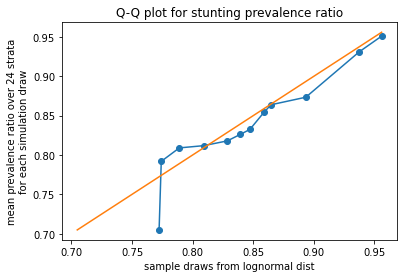

In [69]:
start = min(mean_prevalence_ratio_by_draw.min(), lognormal_draws[0])
end = max(mean_prevalence_ratio_by_draw.max(), lognormal_draws[-1])
plt.plot(lognormal_draws, mean_prevalence_ratio_by_draw, '-o')
plt.plot((start, end), (start, end), '-')
plt.xlabel("sample draws from lognormal dist")
plt.ylabel("mean prevalence ratio over 24 strata\nfor each simulation draw")
plt.title("Q-Q plot for stunting prevalence ratio");

In [ ]:
plt.plot()

## Verify that prevalence ratios match the targets for each stunting category

Targets:
- cat1 (severe stunting): 0.85 (95% CI 0.74 to 0.98)
- cat2 (moderate stunting): 0.93 (95% CI 0.88 to 0.98)
- cat3 (mild stunting): Ratio depends on the category prevalences for the stratum -- should be greater than 1
- cat4 (TMREL): 1.0 (no uncertainty)
 
The sim means are matching the targets quite well, but there is less variation than I would expect from our specified uncertainty. This could be because we only have 12 draws, or because the ratios for different strata are not independent within the same draw, or both. Or it could be related to my comment above about the parameter uncertainty behaving differently from my expectations. Or it could be none of these. I'm not sure how to correctly stratify our resuls to verify that the uncertainty matches our specification.

**Explanation:** As of 9/13/2021, the the simulation is not including *any* parameter uncertainty for this effect size, so all of the observed variation here must be due to stochastic variation within the sim.

### Looks like the prevalence ratios are similar across years for each stunting category, so we can plot all years together

Which makes sense given the explanation above.

## Severe stunting (cat1) prevalence ratios

In [134]:
stunting_prevalence_ratio.query("stunting_state == 'cat1'").groupby('year').value.describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
year,,,,,,,,
2023,72.0,0.837525,0.067380,0.673237,0.700118,0.836571,0.966879,1.026946
2024,72.0,0.837057,0.065628,0.689543,0.693708,0.836894,0.942357,0.984113
2025,72.0,0.840784,0.067251,0.693884,0.701770,0.830066,0.970202,1.050973
2026,72.0,0.840333,0.067271,0.642026,0.704092,0.834579,0.973111,0.989742


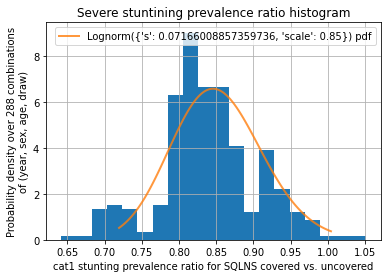

In [245]:
stunting_prevalence_ratio.query("stunting_state == 'cat1'").value.hist(bins=20, density=True)
plt.xlabel("cat1 stunting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("Severe stuntining prevalence ratio histogram")
lognormal_dist = lognorm_from_median_lower_upper(0.85, 0.74, 0.98) # 0.85 (95% CI 0.74 to 0.98)
plot_pdf(lognormal_dist, f'Lognorm({lognormal_dist.kwds}) pdf')
plt.legend();

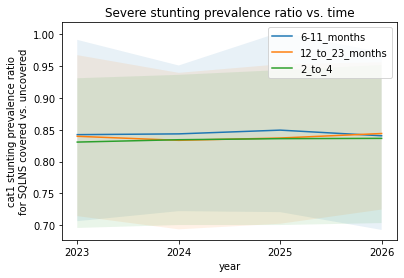

In [136]:
plot_over_time_by_age(
    stunting_prevalence_ratio.query("stunting_state == 'cat1'"),
    "cat1 stunting prevalence ratio\nfor SQLNS covered vs. uncovered",
    "Severe stunting prevalence ratio vs. time"
);

# Moderate stunting (cat2) prevalence ratios

In [137]:
stunting_prevalence_ratio.query("stunting_state == 'cat2'").groupby('year').value.describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
year,,,,,,,,
2023,72.0,0.934619,0.039102,0.855091,0.877288,0.934096,1.007664,1.058991
2024,72.0,0.930450,0.034517,0.870533,0.878568,0.930110,1.003663,1.031872
2025,72.0,0.930241,0.031957,0.881131,0.885439,0.927928,1.014978,1.018051
2026,72.0,0.928220,0.029088,0.880532,0.885316,0.923925,0.985091,0.986056


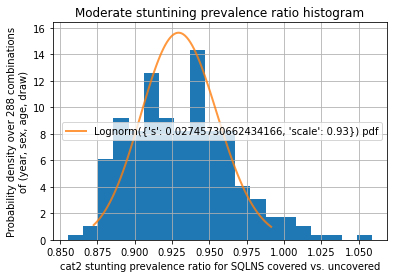

In [246]:
stunting_prevalence_ratio.query("stunting_state == 'cat2'").value.hist(bins=20, density=True)
plt.xlabel("cat2 stunting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("Moderate stuntining prevalence ratio histogram")
lognormal_dist = lognorm_from_median_lower_upper(0.93, 0.88, 0.98) # 0.93 (95% CI 0.88 to 0.98)
plot_pdf(lognormal_dist, f'Lognorm({lognormal_dist.kwds}) pdf')
plt.legend();

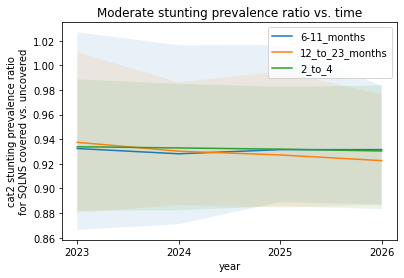

In [139]:
plot_over_time_by_age(
    stunting_prevalence_ratio.query("stunting_state == 'cat2'"),
    "cat2 stunting prevalence ratio\nfor SQLNS covered vs. uncovered",
    "Moderate stunting prevalence ratio vs. time"
);

# Mild stunting (cat3) prevalence ratios

In [140]:
stunting_prevalence_ratio.query("stunting_state == 'cat3'").groupby('year').value.describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
year,,,,,,,,
2023,72.0,1.176809,0.080180,1.042383,1.050565,1.166665,1.338505,1.401521
2024,72.0,1.179932,0.082144,1.037423,1.052364,1.176138,1.368400,1.382526
2025,72.0,1.178544,0.082496,1.036587,1.044537,1.169836,1.368821,1.371648
2026,72.0,1.181221,0.079551,1.038673,1.057971,1.173855,1.367146,1.384445


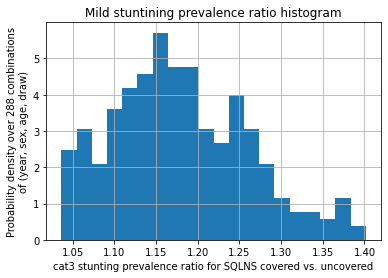

In [141]:
stunting_prevalence_ratio.query("stunting_state == 'cat3'").value.hist(bins=20, density=True)
plt.xlabel("cat3 stunting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("Mild stuntining prevalence ratio histogram");

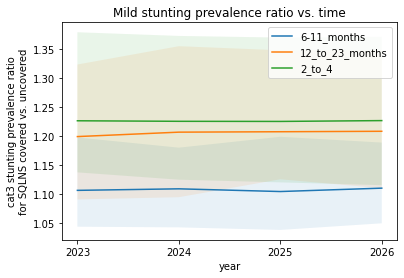

In [142]:
plot_over_time_by_age(
    stunting_prevalence_ratio.query("stunting_state == 'cat3'"),
    "cat3 stunting prevalence ratio\nfor SQLNS covered vs. uncovered",
    "Mild stunting prevalence ratio vs. time"
);

### The ratios for `cat3` vary significantly by age and sex; the above histogram is a mixture of ratios for 6 strata

The variation by age and sex is expected, and we have no specific target value for this category, though the prevalence ratio should be greater than 1.

In [143]:
stunting_prevalence_ratio.query(
    "stunting_state == 'cat3'"
).groupby(['sex']).value.describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
sex,,,,,,,,
female,144.0,1.156998,0.069574,1.036587,1.040806,1.153997,1.287384,1.301792
male,144.0,1.201255,0.085099,1.046240,1.067752,1.187050,1.380883,1.401521


In [144]:
stunting_prevalence_ratio.query(
    "stunting_state == 'cat3'"
).groupby(['age']).value.describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
age,,,,,,,,
12_to_23_months,96.0,1.204902,0.067932,1.068498,1.100925,1.192874,1.357426,1.384445
2_to_4,96.0,1.225422,0.069810,1.114309,1.117633,1.232185,1.376305,1.401521
6-11_months,96.0,1.107057,0.045802,1.036587,1.038672,1.103519,1.193257,1.235809


In [145]:
stunting_prevalence_ratio.query(
    "stunting_state == 'cat3'"
).groupby(['age', 'sex']).value.describe(percentiles=[0.025,0.975])

count      mean       std       min      2.5%  \
age             sex                                                     
12_to_23_months female   48.0  1.173550  0.043755  1.070322  1.099154   
                male     48.0  1.236253  0.073521  1.068498  1.123384   
2_to_4          female   48.0  1.211911  0.054572  1.114558  1.122191   
                male     48.0  1.238932  0.080620  1.114309  1.117022   
6-11_months     female   48.0  1.085532  0.035491  1.036587  1.037641   
                male     48.0  1.128581  0.045103  1.046240  1.055950   

                             50%     97.5%       max  
age             sex                                   
12_to_23_months female  1.176649  1.258504  1.264029  
                male    1.245914  1.380439  1.384445  
2_to_4          female  1.219392  1.298363  1.301792  
                male    1.232716  1.382055  1.401521  
6-11_months     female  1.079034  1.152738  1.175591  
                male    1.140285  1.200424  1.235809

# TMREL stunting (cat4) prevalence ratios

In [146]:
stunting_prevalence_ratio.query("stunting_state == 'cat4'").groupby('year').value.describe(percentiles=[0.025,0.975])

,count,mean,std,min,2.5%,50%,97.5%,max
year,,,,,,,,
2023,72.0,0.998225,0.011160,0.966562,0.978670,0.998336,1.019674,1.027223
2024,72.0,0.999164,0.010555,0.962685,0.979916,0.998856,1.016842,1.026452
2025,72.0,0.998696,0.009407,0.979148,0.981715,0.998383,1.018427,1.022204
2026,72.0,0.997915,0.008573,0.980463,0.983341,0.997872,1.020833,1.021667


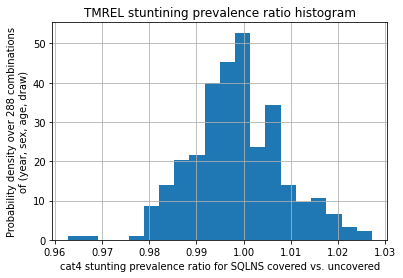

In [147]:
stunting_prevalence_ratio.query("stunting_state == 'cat4'").value.hist(bins=20, density=True)
plt.xlabel("cat4 stunting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("TMREL stuntining prevalence ratio histogram");

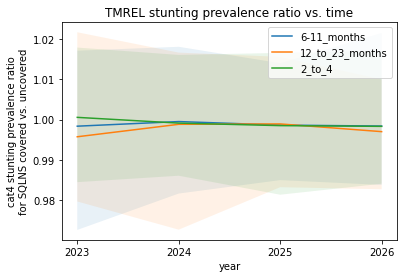

In [148]:
plot_over_time_by_age(
    stunting_prevalence_ratio.query("stunting_state == 'cat4'"),
    "cat4 stunting prevalence ratio\nfor SQLNS covered vs. uncovered",
    "TMREL stunting prevalence ratio vs. time"
);

# 3. Verify incidence of moderate wasting from mild in supplemented vs non-supplemented group

From the [SQLNS documentation](https://vivarium-research.readthedocs.io/en/latest/intervention_models/lipid_based_nutrient_supplements/index.html#vivarium-modeling-strategy):

> LNS plus complementary feeding reduced the prevalence of moderate wasting by 18% (RR 0.82, 95% CI 0.74 to 0.91; eight studies; 13,172 participants; moderate-quality evidence).
>
> We will apply the relative risk ratio as a relative rate ratio on the incidence of MAM from MILD (i2) starting from the age-start of the intervention starts (6 months). This is because we assume that the intervention does not affect the duration of disease and hence:
>
> Prevalence_intervention
> = 0.82 x (prevalence_baseline_6mo)
> = 0.82 x (incidence_baseline_6mo) x Duration_baseline

### Check geometric and arithmetic mean for the confidence interval

What distribution is most appropriate to model uncertainty for this effect size?

The central value .82 is closer to the geometric mean than the arithmetic mean. So the interval is asymmetric, and a lognormal distribution might model uncertainty better than a normal distribution.

Also, a ratio of independent [lognormal distributions](https://en.wikipedia.org/wiki/Log-normal_distribution) is again lognormal, so if we assume that the rates are lognormally distributed, then the ratio will be as well.

In [149]:
np.sqrt(.74*.91)

0.8206095295571457

In [150]:
(.74+.91)/2

0.825

## Look at input data for wasting incidence ratio

In [151]:
data.wasting_transition_count

,sex,year,measure,input_draw,scenario,value,sq_lns,wasting_treatment,age,transition,from_state,to_state
0,female,2022,transition_count,29,baseline,0.0,covered,covered,early_neonatal,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition
1,female,2022,transition_count,29,baseline,0.0,covered,uncovered,early_neonatal,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition
2,female,2022,transition_count,29,baseline,0.0,uncovered,covered,early_neonatal,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition
3,female,2022,transition_count,29,baseline,0.0,uncovered,uncovered,early_neonatal,mild_child_wasting_to_moderate_acute_malnutrition,mild_child_wasting,moderate_acute_malnutrition
...,...,...,...,...,...,...,...,...,...,...,...,...
60476,male,2026,transition_count,946,wasting_treatment,0.0,covered,covered,2_to_4,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting
60477,male,2026,transition_count,946,wasting_treatment,0.0,covered,uncovered,2_to_4,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting
60478,male,2026,transition_count,946,wasting_treatment,0.0,uncovered,covered,2_to_4,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting
60479,male,2026,transition_count,946,wasting_treatment,1633.0,uncovered,uncovered,2_to_4,susceptible_to_child_wasting_to_mild_child_was...,susceptible_to_child_wasting,mild_child_wasting


In [152]:
data.wasting_transition_count.transition.unique()

array(['mild_child_wasting_to_moderate_acute_malnutrition',
       'mild_child_wasting_to_susceptible_to_child_wasting',
       'moderate_acute_malnutrition_to_mild_child_wasting',
       'moderate_acute_malnutrition_to_severe_acute_malnutrition',
       'severe_acute_malnutrition_to_mild_child_wasting',
       'severe_acute_malnutrition_to_moderate_acute_malnutrition',
       'susceptible_to_child_wasting_to_mild_child_wasting'], dtype=object)

In [153]:
data.wasting_state_person_time.query("wasting_state=='mild_child_wasting'")

,sex,year,wasting_state,measure,input_draw,scenario,value,sq_lns,wasting_treatment,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,covered,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,uncovered,early_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,144.720055,uncovered,covered,early_neonatal
3,female,2022,mild_child_wasting,state_person_time,29,baseline,149.426420,uncovered,uncovered,early_neonatal
...,...,...,...,...,...,...,...,...,...,...
31964,male,2026,mild_child_wasting,state_person_time,946,wasting_treatment,0.000000,covered,covered,2_to_4
31965,male,2026,mild_child_wasting,state_person_time,946,wasting_treatment,0.000000,covered,uncovered,2_to_4
31966,male,2026,mild_child_wasting,state_person_time,946,wasting_treatment,0.000000,uncovered,covered,2_to_4
31967,male,2026,mild_child_wasting,state_person_time,946,wasting_treatment,5100.670773,uncovered,uncovered,2_to_4


In [154]:
list(csr.ages_categorical[(csr.ages_categorical >= '6-11_months') & (csr.ages_categorical != 'all_ages')])

['6-11_months', '12_to_23_months', '2_to_4']

## Compute MAM incidence rate ratio

In [156]:
mam_incidence_rate_ratio = csr.get_sqlns_mam_incidence_ratio(data)
mam_incidence_rate_ratio

,year,sex,age,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier
0,2023,female,12_to_23_months,29,sqlns,0.769606,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
1,2023,female,12_to_23_months,223,sqlns,0.672831,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
2,2023,female,12_to_23_months,232,sqlns,0.706144,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
3,2023,female,12_to_23_months,357,sqlns,0.647320,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
...,...,...,...,...,...,...,...,...,...
284,2026,male,6-11_months,650,sqlns,0.755324,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
285,2026,male,6-11_months,680,sqlns,0.807180,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
286,2026,male,6-11_months,829,sqlns,0.869562,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
287,2026,male,6-11_months,946,sqlns,0.842789,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1


In [229]:
mam_incidence_rate_ratio.scenario.unique()

array(['sqlns'], dtype=object)

## View overall distribution of incidence ratios

The mean looks slightly low (.81 vs. .82). Let's dig into the data further to see what's going on.

In [157]:
mam_incidence_rate_ratio.value.describe(percentiles=[.025,.975])

count    288.000000
mean       0.797823
std        0.066210
min        0.601614
2.5%       0.672521
50%        0.804514
97.5%      0.919165
max        0.992324
Name: value, dtype: float64

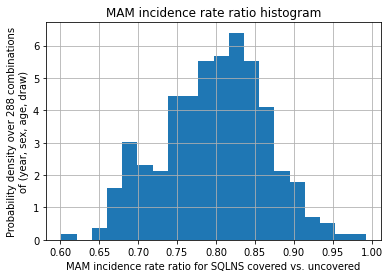

In [158]:
mam_incidence_rate_ratio.value.hist(bins=20, density=True)
plt.xlabel("MAM incidence rate ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("MAM incidence rate ratio histogram");

## Stratify by year, sex and age to see any trends

- The MAM incidence ratio is smaller in the first year (.80 vs. .81)
- As expected, there is no significant difference in ratios between males and females
- The incidence ratio for 6-11-month-olds is significantly low, only .79-.80, while the ratios for the two older age groups are close to the target value .82

In [159]:
mam_incidence_rate_ratio.groupby('year').value.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2023,72.0,0.727186,0.048293,0.601614,0.692161,0.717232,0.760194,0.828468
2024,72.0,0.826339,0.053562,0.696862,0.793000,0.825725,0.855185,0.992324
2025,72.0,0.819039,0.051029,0.692454,0.787789,0.818640,0.854477,0.920555
2026,72.0,0.818727,0.055956,0.693087,0.780682,0.816890,0.857546,0.966265


In [160]:
mam_incidence_rate_ratio.groupby(['year', 'sex']).value.describe()

count      mean       std       min       25%       50%  \
year sex                                                               
2023 female   36.0  0.733725  0.049031  0.647320  0.692982  0.742514   
     male     36.0  0.720646  0.047319  0.601614  0.691498  0.713036   
2024 female   36.0  0.826542  0.059012  0.696862  0.793000  0.825929   
     male     36.0  0.826136  0.048346  0.700902  0.792886  0.825725   
2025 female   36.0  0.809907  0.051138  0.692454  0.779208  0.816822   
     male     36.0  0.828172  0.049956  0.734458  0.794137  0.823152   
2026 female   36.0  0.820448  0.062438  0.693087  0.778645  0.823855   
     male     36.0  0.817006  0.049467  0.737245  0.782250  0.810058   

                  75%       max  
year sex                         
2023 female  0.762770  0.826820  
     male    0.747645  0.828468  
2024 female  0.852004  0.992324  
     male    0.855359  0.940114  
2025 female  0.844017  0.893622  
     male    0.862476  0.920555  
2026 female  0.859916  0.966265  
     male    0.848872  0.940074

In [161]:
mam_incidence_rate_ratio.groupby(['year', 'age']).value.describe()

count      mean       std       min       25%       50%  \
year age                                                                        
2023 12_to_23_months   24.0  0.719033  0.045196  0.647320  0.682701  0.708274   
     2_to_4            24.0  0.725380  0.033470  0.666470  0.702559  0.717242   
     6-11_months       24.0  0.737144  0.062132  0.601614  0.694037  0.743739   
2024 12_to_23_months   24.0  0.821218  0.044131  0.737794  0.793364  0.823074   
...                     ...       ...       ...       ...       ...       ...   
2025 6-11_months       24.0  0.813832  0.064424  0.692454  0.793539  0.811416   
2026 12_to_23_months   24.0  0.836365  0.054356  0.753722  0.802698  0.827658   
     2_to_4            24.0  0.818085  0.043692  0.747573  0.782338  0.818356   
     6-11_months       24.0  0.801730  0.064618  0.693087  0.751491  0.806079   

                           75%       max  
year age                                  
2023 12_to_23_months  0.758642  0.801553  
     2_to_4           0.751813  0.782039  
     6-11_months      0.785764  0.828468  
2024 12_to_23_months  0.847139  0.900769  
...                        ...       ...  
2025 6-11_months      0.859428  0.920555  
2026 12_to_23_months  0.870306  0.940074  
     2_to_4           0.854027  0.907018  
     6-11_months      0.842826  0.966265  

[12 rows x 8 columns]

In [162]:
mam_incidence_rate_ratio.query("year=='2023' and age != '6-11_months'").value.describe()

count    48.000000
mean      0.722206
std       0.039473
min       0.647320
25%       0.689058
50%       0.714709
75%       0.755990
max       0.801553
Name: value, dtype: float64

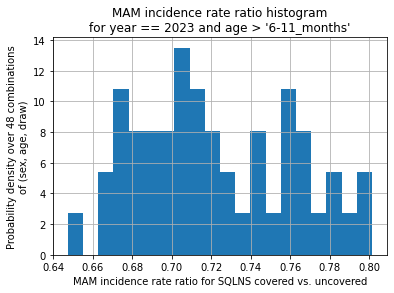

In [163]:
mam_incidence_rate_ratio.query("year=='2023' and age != '6-11_months'").value.hist(bins=20, density=True)
plt.xlabel("MAM incidence rate ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 48 combinations\nof (sex, age, draw)")
plt.title("MAM incidence rate ratio histogram\nfor year == 2023 and age > '6-11_months'");

In [164]:
mam_incidence_rate_ratio.query("year>'2023' and age != '6-11_months'").value.describe()

count    144.000000
mean       0.824897
std        0.045048
min        0.737794
25%        0.789821
50%        0.823635
75%        0.853713
max        0.940074
Name: value, dtype: float64

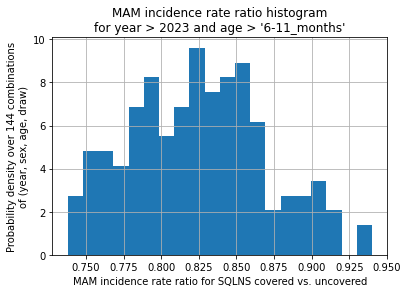

In [165]:
mam_incidence_rate_ratio.query("year>'2023' and age != '6-11_months'").value.hist(bins=20, density=True)
plt.xlabel("MAM incidence rate ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 144 combinations\nof (year, sex, age, draw)")
plt.title("MAM incidence rate ratio histogram\nfor year > 2023 and age > '6-11_months'");

## Plot MAM incidence rate ratio vs. time for each age group > 6 months

The MWM incidence ratio matches the target 0.82 in the older two age groups after the first year. For 6-11-month-olds, it levels off around 0.80.

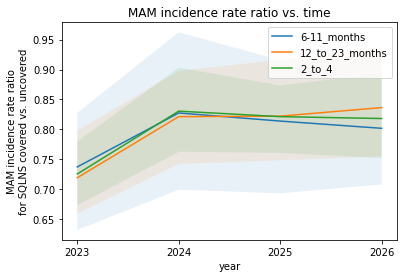

In [233]:
plot_over_time_by_age(
    mam_incidence_rate_ratio,
    'MAM incidence rate ratio\nfor SQLNS covered vs. uncovered',
    'MAM incidence rate ratio vs. time'
);

In [168]:
mam_incidence_rate_ratio

,year,sex,age,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier
0,2023,female,12_to_23_months,29,sqlns,0.769606,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
1,2023,female,12_to_23_months,223,sqlns,0.672831,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
2,2023,female,12_to_23_months,232,sqlns,0.706144,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
3,2023,female,12_to_23_months,357,sqlns,0.647320,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
...,...,...,...,...,...,...,...,...,...
284,2026,male,6-11_months,650,sqlns,0.755324,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
285,2026,male,6-11_months,680,sqlns,0.807180,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
286,2026,male,6-11_months,829,sqlns,0.869562,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1
287,2026,male,6-11_months,946,sqlns,0.842789,mam_incidence_rate_among_sqlns_covered,mam_incidence_rate_among_sqlns_uncovered,1


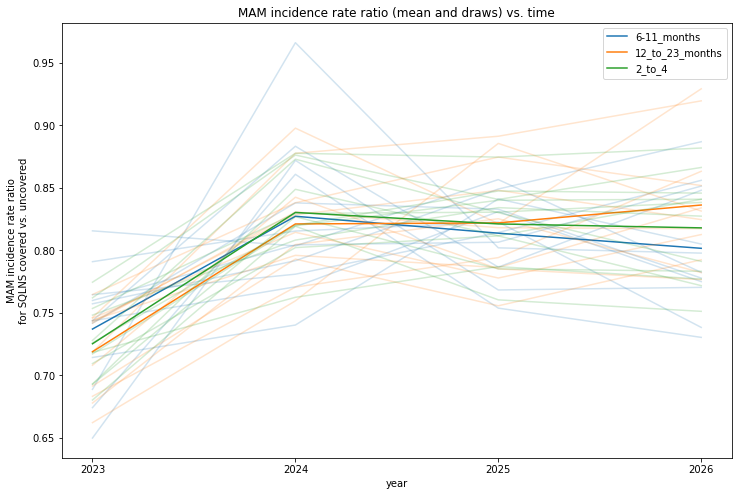

In [237]:
fig, ax = plt.subplots(figsize=(12,8))
plot_draws_over_time_by_age(
    mam_incidence_rate_ratio,
    'MAM incidence rate ratio\nfor SQLNS covered vs. uncovered',
    'MAM incidence rate ratio (mean and draws) vs. time',
    ax=ax
);

# 4. Validation: Check that the prevalence of moderate wasting in supplemented vs non-supplemented group agrees with the prevalence RR that we applied to the incidence instead

The RR applied to the incidence rate of moderate wasting was 0.82 (95% CI 0.74 to 0.91). This was actually a prevalence ratio, so we want to see whether we get the same reduction in prevalence of moderate wasting.

## The prevalence ratio does _not_ agree with the incidence ratio

It is about 0.87 (95% UI 0.83 to 0.92), which is higher than the target 0.82.

### Note from CIFF check-in on 9/13/2021:

We're getting around .88ish in the first year to .86ish remaining years (run burn-in for 1 year?). It's >.82 because some kids are already in MAM state before they are able to get SQ-LNS, correctly producing prev that is higher. In other words, our simulated "study" of the SQLNS intervention is missing the appropriate "exclusion criteria" -- we should be excluding kids who already have MAM if we want to get the right prevalence ratio. We could add stratification by wasting status at 6 months to be able to compute a ratio that should actually agree with our target effect size of 0.82; howeverw, we don't need to dig into this more right now.

## Look at input data and compute wasting prevalence ratio

In [169]:
data.wasting_state_person_time

,sex,year,wasting_state,measure,input_draw,scenario,value,sq_lns,wasting_treatment,age
0,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,covered,early_neonatal
1,female,2022,mild_child_wasting,state_person_time,29,baseline,0.000000,covered,uncovered,early_neonatal
2,female,2022,mild_child_wasting,state_person_time,29,baseline,144.720055,uncovered,covered,early_neonatal
3,female,2022,mild_child_wasting,state_person_time,29,baseline,149.426420,uncovered,uncovered,early_neonatal
...,...,...,...,...,...,...,...,...,...,...
34556,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,0.000000,covered,covered,2_to_4
34557,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,0.000000,covered,uncovered,2_to_4
34558,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,0.000000,uncovered,covered,2_to_4
34559,male,2026,susceptible_to_child_wasting,state_person_time,946,wasting_treatment,15488.375086,uncovered,uncovered,2_to_4


In [238]:
wasting_prevalence_ratio = csr.get_sqlns_risk_prevalence_ratio(data, 'wasting', stratify_by_year=True)
wasting_prevalence_ratio

,year,sex,age,wasting_state,input_draw,scenario,value,numerator_measure,denominator_measure,multiplier
0,2023,female,12_to_23_months,mild_child_wasting,29,sqlns,1.040213,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
1,2023,female,12_to_23_months,mild_child_wasting,223,sqlns,1.007162,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
2,2023,female,12_to_23_months,mild_child_wasting,232,sqlns,1.090376,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
3,2023,female,12_to_23_months,mild_child_wasting,357,sqlns,0.989863,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
...,...,...,...,...,...,...,...,...,...,...
1148,2026,male,6-11_months,susceptible_to_child_wasting,650,sqlns,1.018409,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
1149,2026,male,6-11_months,susceptible_to_child_wasting,680,sqlns,0.994453,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
1150,2026,male,6-11_months,susceptible_to_child_wasting,829,sqlns,1.027973,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1
1151,2026,male,6-11_months,susceptible_to_child_wasting,946,sqlns,1.008168,prevalence_among_sqlns_covered,prevalence_among_sqlns_uncovered,1


In [171]:
wasting_prevalence_ratio.wasting_state.unique()

array(['mild_child_wasting', 'moderate_acute_malnutrition',
       'severe_acute_malnutrition', 'susceptible_to_child_wasting'],
      dtype=object)

## Look at the distribution of MAM prevalence ratios

Overall, it is around 0.87, higher than our target of 0.82.

In [172]:
wasting_prevalence_ratio.query(
    "wasting_state == 'moderate_acute_malnutrition'").value.describe(percentiles=[.025, .975])

count    288.000000
mean       0.888661
std        0.060543
min        0.723499
2.5%       0.782252
50%        0.881250
97.5%      1.016365
max        1.039731
Name: value, dtype: float64

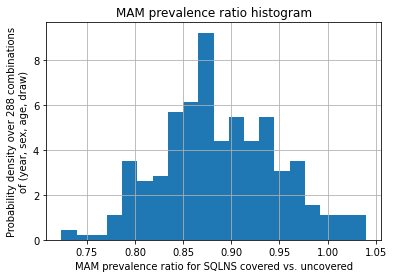

In [173]:
wasting_prevalence_ratio.query("wasting_state == 'moderate_acute_malnutrition'").value.hist(bins=20, density=True)
plt.xlabel("MAM prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("MAM prevalence ratio histogram");

## Stratify by year and age group to see if we find any trends

It starts off higher and then decreases. It also decreases as age increases.

In [174]:
wasting_prevalence_ratio.query(
    "wasting_state == 'moderate_acute_malnutrition'").groupby('year').value.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2023,72.0,0.915276,0.056427,0.728762,0.870195,0.914686,0.963084,1.024219
2024,72.0,0.889094,0.055326,0.781518,0.845941,0.896947,0.931038,1.018997
2025,72.0,0.874974,0.064947,0.723499,0.832317,0.871927,0.905830,1.039731
2026,72.0,0.875301,0.057130,0.754857,0.841376,0.866456,0.907992,1.035322


In [175]:
wasting_prevalence_ratio.query(
    "wasting_state == 'moderate_acute_malnutrition' and age == '12_to_23_months'"
).groupby('year').value.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2023,24.0,0.920482,0.063654,0.728762,0.893428,0.928927,0.964097,1.023472
2024,24.0,0.880799,0.049063,0.799104,0.843178,0.884682,0.916076,0.956579
2025,24.0,0.864341,0.058566,0.723499,0.822914,0.870481,0.892357,0.983933
2026,24.0,0.867829,0.063412,0.754857,0.830828,0.855568,0.890636,1.033559


In [176]:
wasting_prevalence_ratio.query(
    "wasting_state == 'moderate_acute_malnutrition' and age == '2_to_4'"
).groupby('year').value.describe()

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2023,24.0,0.897452,0.039997,0.848932,0.864171,0.886168,0.931134,0.971922
2024,24.0,0.867347,0.044944,0.797792,0.840915,0.857410,0.903073,0.940891
2025,24.0,0.865050,0.057608,0.776917,0.823396,0.862576,0.891637,1.039731
2026,24.0,0.861225,0.045315,0.776536,0.843545,0.862116,0.882020,0.973556


## Plot MAM prvalence ratio vs. time for each age group

For each age group, it starts off high, then decreases and appears to level off.

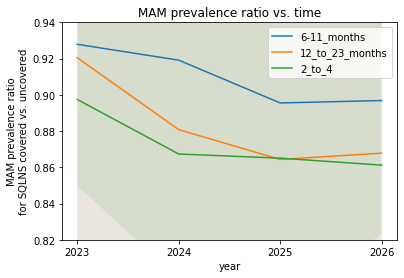

In [239]:
plot_over_time_by_age(
    wasting_prevalence_ratio.query("wasting_state == 'moderate_acute_malnutrition'"),
    'MAM prevalence ratio\nfor SQLNS covered vs. uncovered',
    "MAM prevalence ratio vs. time"
)
plt.ylim((.82, .94));

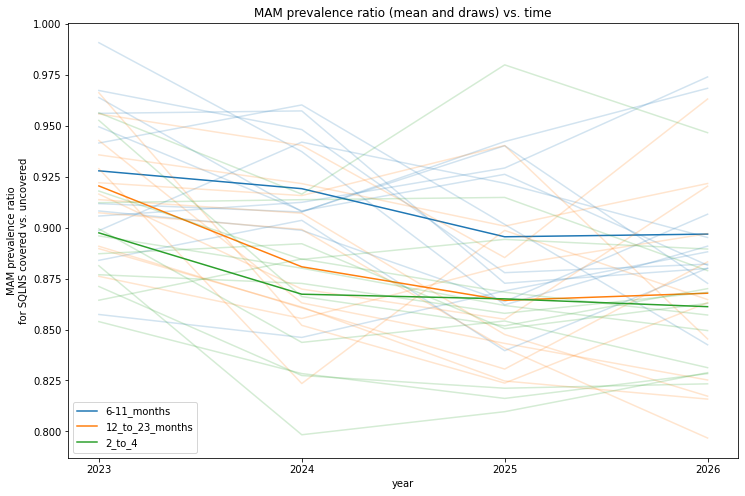

In [244]:
fig, ax = plt.subplots(figsize=(12,8))
plot_draws_over_time_by_age(
    wasting_prevalence_ratio.query("wasting_state == 'moderate_acute_malnutrition'"),
    'MAM prevalence ratio\nfor SQLNS covered vs. uncovered',
    "MAM prevalence ratio (mean and draws) vs. time",
    ax
);
# plt.ylim((.82, .94));

# 5. Validation: Check to see how much of SAM prevalence decreases from reduction in MAM incidence from MILD

Since the prevalence of MAM has increased, there will be fewer people transitioning from MAM into SAM, so the prevalence of SAM should decrase as well. But how much?

The prevalence of SAM decreases by a factor of 0.89 (95% UI 0.81 to 1.0).

In [179]:
wasting_prevalence_ratio.query(
    "wasting_state == 'severe_acute_malnutrition'"
).groupby('age').value.describe(percentiles=[.025, .975])

,count,mean,std,min,2.5%,50%,97.5%,max
age,,,,,,,,
12_to_23_months,96.0,0.890875,0.113476,0.661117,0.690704,0.886662,1.116212,1.235718
2_to_4,96.0,0.892939,0.086147,0.703571,0.767409,0.884181,1.071719,1.113002
6-11_months,96.0,0.970881,0.141465,0.674769,0.754680,0.971261,1.276618,1.351666


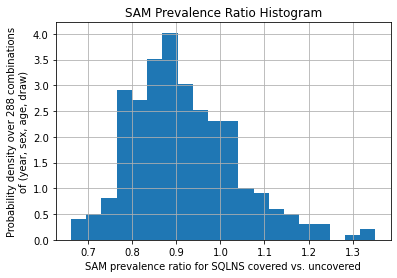

In [180]:
wasting_prevalence_ratio.query("wasting_state == 'severe_acute_malnutrition'").value.hist(bins=20, density=True)
plt.xlabel("SAM prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("SAM Prevalence Ratio Histogram");

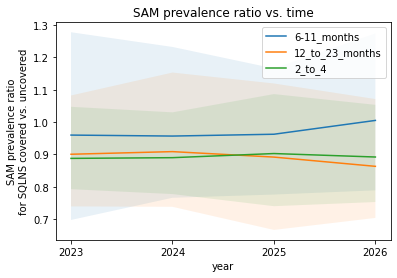

In [181]:
plot_over_time_by_age(
    wasting_prevalence_ratio.query("wasting_state == 'severe_acute_malnutrition'"),
    'SAM prevalence ratio\nfor SQLNS covered vs. uncovered',
    "SAM prevalence ratio vs. time"
);

# 6. Just for kicks, let's look at the prevalence ratios for the other two wasting categories

It looks like mild wasting prevalence increases slightly, and TMREL prevalence stays about the same.

In [182]:
wasting_prevalence_ratio.query(
    "wasting_state == 'mild_child_wasting'").groupby('age').value.describe(percentiles=[.025, .975])

,count,mean,std,min,2.5%,50%,97.5%,max
age,,,,,,,,
12_to_23_months,96.0,1.052997,0.047911,0.946608,0.983017,1.047063,1.157602,1.181004
2_to_4,96.0,1.045075,0.030728,0.979653,0.984988,1.046219,1.104962,1.109972
6-11_months,96.0,1.044447,0.071554,0.895803,0.904281,1.029840,1.210227,1.270135


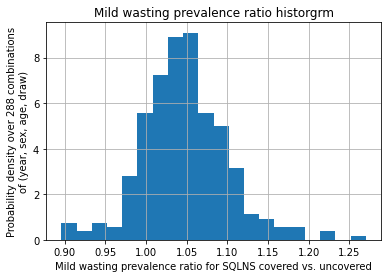

In [183]:
wasting_prevalence_ratio.query("wasting_state == 'mild_child_wasting'").value.hist(bins=20, density=True)
plt.xlabel("Mild wasting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("Mild wasting prevalence ratio historgrm");

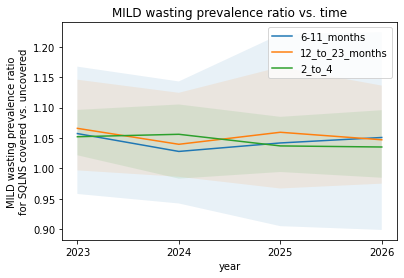

In [184]:
plot_over_time_by_age(
    wasting_prevalence_ratio.query("wasting_state == 'mild_child_wasting'"),
    'MILD wasting prevalence ratio\nfor SQLNS covered vs. uncovered',
    "MILD wasting prevalence ratio vs. time"
);

In [185]:
wasting_prevalence_ratio.query(
    "wasting_state == 'susceptible_to_child_wasting'"
).groupby('age').value.describe(percentiles=[.025, .975])

,count,mean,std,min,2.5%,50%,97.5%,max
age,,,,,,,,
12_to_23_months,96.0,1.007614,0.022602,0.954486,0.964362,1.007448,1.044984,1.096415
2_to_4,96.0,1.005436,0.013857,0.974379,0.981019,1.005331,1.035154,1.036970
6-11_months,96.0,1.005526,0.027509,0.937648,0.959240,1.001191,1.057777,1.087073


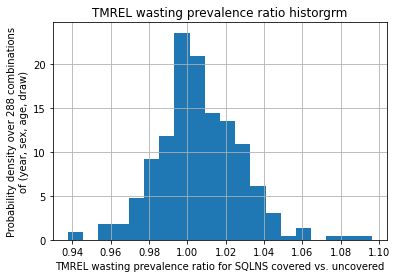

In [186]:
wasting_prevalence_ratio.query("wasting_state == 'susceptible_to_child_wasting'").value.hist(bins=20, density=True)
plt.xlabel("TMREL wasting prevalence ratio for SQLNS covered vs. uncovered")
plt.ylabel("Probability density over 288 combinations\nof (year, sex, age, draw)")
plt.title("TMREL wasting prevalence ratio historgrm");

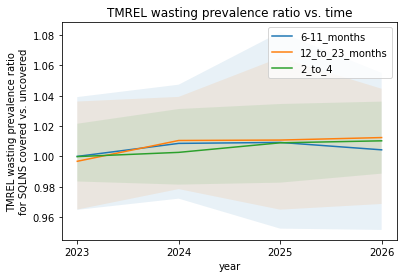

In [187]:
plot_over_time_by_age(
    wasting_prevalence_ratio.query("wasting_state == 'susceptible_to_child_wasting'"),
    'TMREL wasting prevalence ratio\nfor SQLNS covered vs. uncovered',
    "TMREL wasting prevalence ratio vs. time"
);

# 7. Verify that prevalence of wasting and stunting categories among the untreated in the intervention scenario match the prevalences in the baseline scenario

Not done yet.